This is the main code with BoW and term frequency.

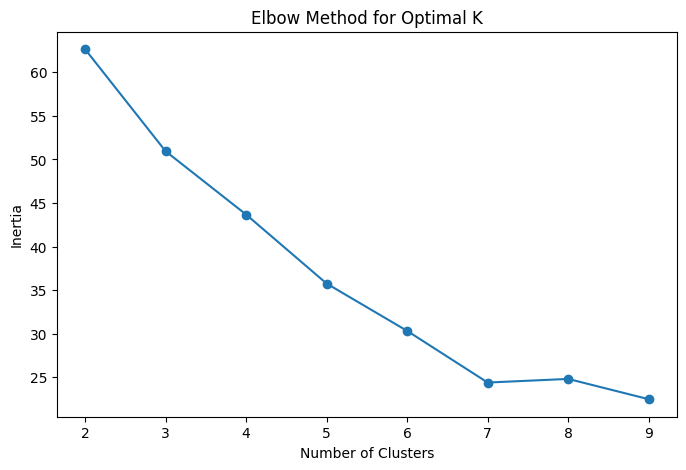


Genre Percentage in Each Cluster:

genre    classical  country  hip-hop    pop   rock
Cluster                                           
0            67.74    16.13     0.00  16.13   0.00
1             0.00     0.00    70.59  29.41   0.00
2             0.00    38.46     0.00  15.38  46.15
3            35.29     5.88    35.29  23.53   0.00
4             0.00    34.62     0.00  19.23  46.15


<ipython-input-30-01632df51fa9>:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df['Cluster'], palette='pastel')


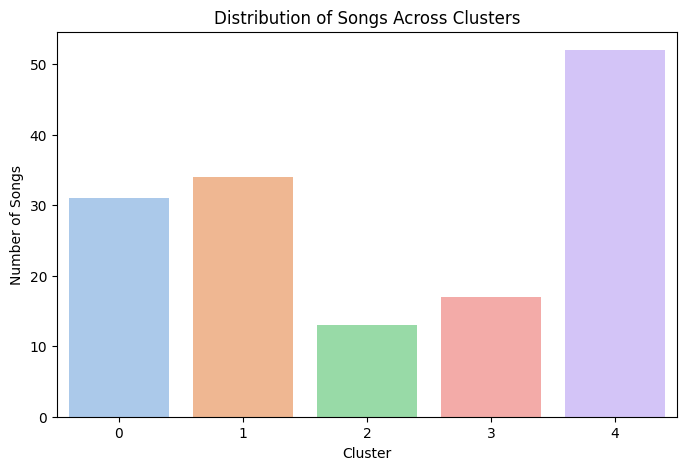

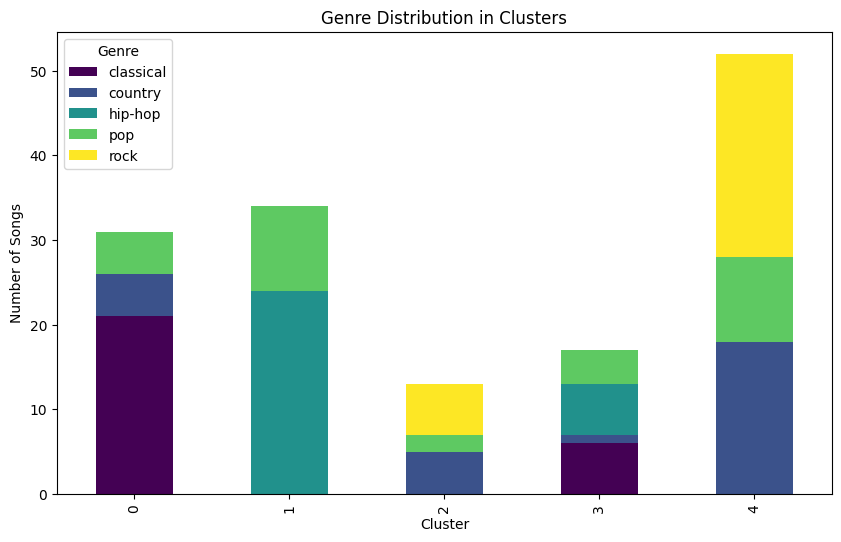

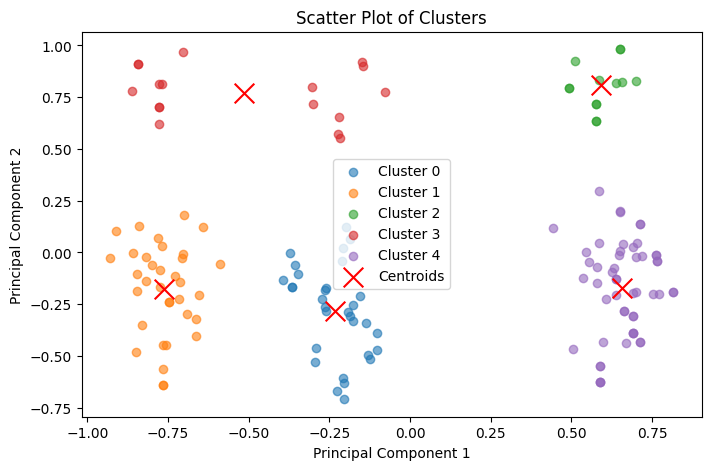

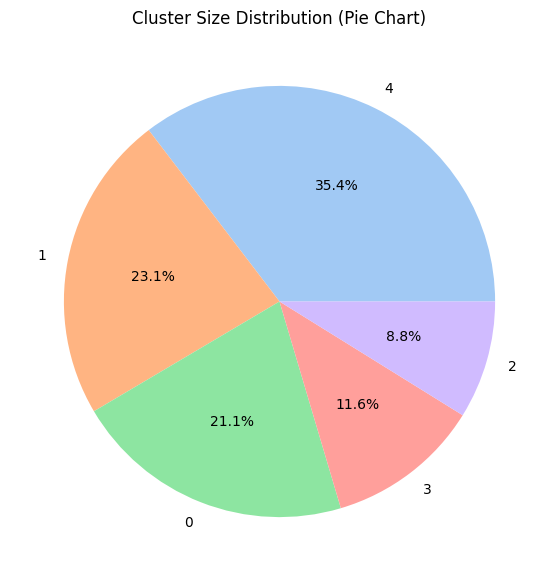

<ipython-input-30-01632df51fa9>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')


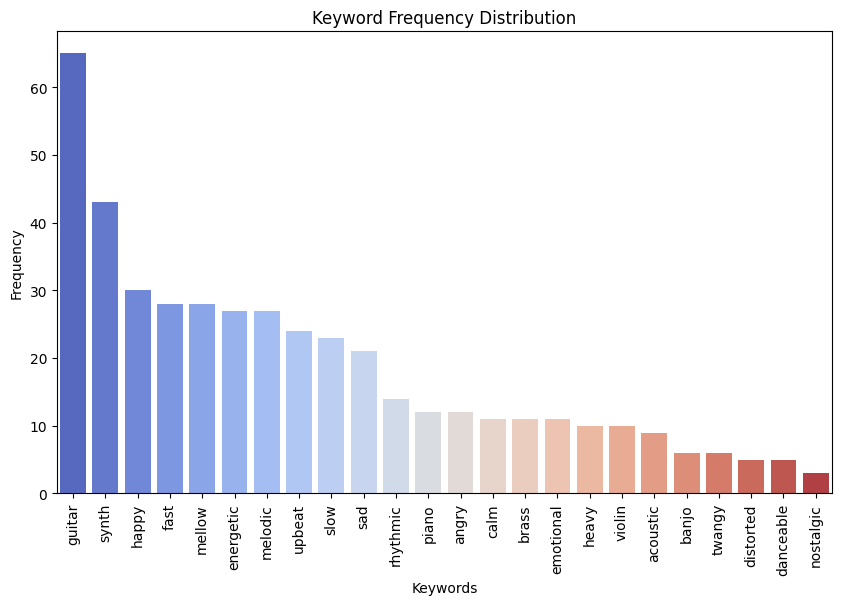

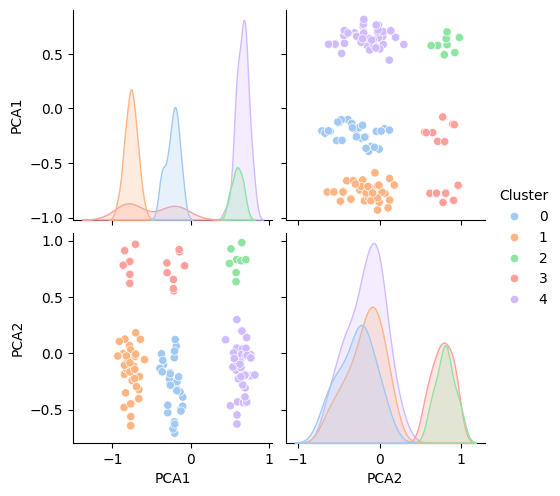

<ipython-input-30-01632df51fa9>:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=silhouette_scores, palette='pastel')


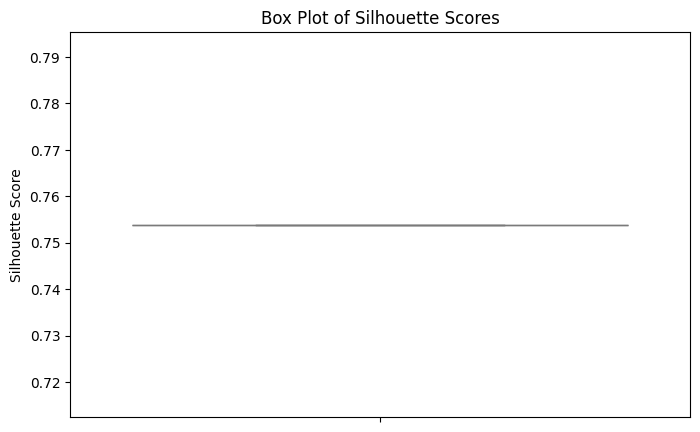

Silhouette Score: 0.7539
Adjusted Rand Index: 0.3209
Davies-Bouldin Index: 0.5724
Predicted genre for ['piano', 'calm', 'slow']: classical
Predicted genre for ['guitar', 'emotional', 'distorted']: rock
Predicted genre for ['synth', 'mellow', 'distorted']: hip-hop


In [30]:
### Cell 1: Import Libraries          !!!NOTE MAIN CODE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cell 2: Define the MusicClustering Class
class MusicClustering:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path) # Load the dataset from a CSV file
        self.keyword_vectors = None # Term frequency matrix
        self.final_embeddings = None # Reduced dimensionality representations
        self.labels = None  # Cluster labels
        self.centroids = None   # Cluster labels
        self.mean_vec = None  # Cluster centroids
        self.principal_components = None   # Principal component vectors

    def compute_bow(self):
       # Extract keywords from the dataset
       # Identify unique keywords to form a vocabulary
       #Create a mapping of keywords to indices'
       # Initialize a term frequency matrix (BoW representation)
       # Populate the term frequency matrix
        keywords = self.df[['keyword_1', 'keyword_2', 'keyword_3']].astype(str)
        unique_keywords = np.unique(keywords.values.flatten())  # Get all unique words
        keyword_to_index = {word: i for i, word in enumerate(unique_keywords)}
        term_frequency = np.zeros((len(self.df), len(unique_keywords)))
        for i, row in self.df.iterrows():
            word_list = row[['keyword_1', 'keyword_2', 'keyword_3']].tolist()
            # Count occurrences manually (instead of just marking presence)
            for word in word_list:
                if word in keyword_to_index:
                    term_frequency[i, keyword_to_index[word]] += 1
        self.keyword_vectors = term_frequency  # Store BoW representation
        return term_frequency

### Cell 3: Apply PCA for Dimensionality Reduction
    def apply_pca(self):
      # Compute mean vector of term frequency matrix
      # Center the data (subtract mean)
      # Compute covariance matrix
      # Compute eigenvalues and eigenvectors
      # Sort eigenvalues in descending order
      # Select the top 2 principal components for visualization
      # Project data onto the top 2 principal components
        self.mean_vec = np.mean(self.keyword_vectors, axis=0)
        centered_data = self.keyword_vectors - self.mean_vec
        cov_matrix = np.dot(centered_data.T, centered_data) / (len(centered_data) - 1)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.principal_components = eigenvectors[:, sorted_indices[:2]]
        reduced_vectors = np.dot(centered_data, self.principal_components)
        self.final_embeddings = reduced_vectors

### Cell 4: Determine Optimal K using Elbow Method
    def elbow_method(self, k_range=range(2, 10)):
        # Store inertia values for different k
        # Iterate over different values of k
        # Randomly initialize k centroids
        # Iterate to refine centroids
        # Compute inertia
        # Plot elbow method results
        inertia = []
        for k in k_range:
            centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
            for _ in range(10):
                distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - centroids) ** 2).sum(axis=2))
                labels = np.argmin(distances, axis=1)
                centroids = np.array([self.final_embeddings[labels == j].mean(axis=0) for j in range(k)])
            inertia.append(np.sum(np.min(distances, axis=1)))
        #plot for elbow curve
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.show()

### Cell 5: Perform K-Means Clustering
    def k_means_clustering(self, k=5):
      # Initialize k random centroids
      # Iterate to refine centroids
      # Store cluster label
        self.centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
        for _ in range(10):
            distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
            self.labels = np.argmin(distances, axis=1)
            self.centroids = np.array([self.final_embeddings[self.labels == j].mean(axis=0) for j in range(k)])
        self.df['Cluster'] = self.labels

### percentage of genre in clusters
    def genre_percentage_in_clusters(self):
        genre_cluster_distribution = self.df.groupby(["Cluster", "genre"]).size().unstack(fill_value=0)
        genre_percentage = genre_cluster_distribution.div(genre_cluster_distribution.sum(axis=1), axis=0) * 100
        print("\nGenre Percentage in Each Cluster:\n")
        print(genre_percentage.round(2))

### Cell 6: Analyze Clusters with Visualizations
    def analyze_clusters(self):
        #plot for clusters vs no. of songs
        plt.figure(figsize=(8, 5))
        sns.countplot(x=self.df['Cluster'], palette='pastel')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Songs')
        plt.title('Distribution of Songs Across Clusters')
        plt.show()
        #Genre distribution in cluster
        genre_cluster_distribution = self.df.groupby(['Cluster', 'genre']).size().unstack(fill_value=0)
        genre_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Songs')
        plt.title('Genre Distribution in Clusters')
        plt.legend(title='Genre')
        plt.show()
        # Scatter plot for cluster visualization
        plt.figure(figsize=(8, 5))
        for cluster in np.unique(self.labels):
            plt.scatter(self.final_embeddings[self.labels == cluster, 0],
                        self.final_embeddings[self.labels == cluster, 1],
                        label=f'Cluster {cluster}', alpha=0.6)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='x', s=200, color='red', label='Centroids')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Scatter Plot of Clusters')
        plt.legend()
        plt.show()
        # Cluster Size Distribution - Pie Chart
        plt.figure(figsize=(7, 7))
        self.df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title('Cluster Size Distribution (Pie Chart)')
        plt.ylabel('')
        plt.show()

        # Keyword Frequency Plot
        keyword_series = self.df[['keyword_1', 'keyword_2', 'keyword_3']].stack().value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')
        plt.xticks(rotation=90)
        plt.xlabel('Keywords')
        plt.ylabel('Frequency')
        plt.title('Keyword Frequency Distribution')
        plt.show()

        # Pairplot for clusters
        plot_df = pd.DataFrame({
            'PCA1': self.final_embeddings[:, 0],
            'PCA2': self.final_embeddings[:, 1],
            'Cluster': self.labels
        })
        sns.pairplot(plot_df, hue='Cluster', palette='pastel', diag_kind='kde')
        plt.show()

        # Box Plot of Silhouette Scores
        silhouette_scores = [self.silhouette_score_np() for _ in range(10)]
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=silhouette_scores, palette='pastel')
        plt.ylabel('Silhouette Score')
        plt.title('Box Plot of Silhouette Scores')
        plt.show()

### Cell 7: Compute Evaluation Metrics
    def silhouette_score_np(self):
        unique_labels = np.unique(self.labels)
        silhouette_scores = []
        for i in range(len(self.final_embeddings)):
            same_cluster = self.final_embeddings[self.labels == self.labels[i]]
            other_clusters = self.final_embeddings[self.labels != self.labels[i]]
            a = np.mean(np.sqrt(((same_cluster - self.final_embeddings[i]) ** 2).sum(axis=1)))
            b = np.mean(np.sqrt(((other_clusters - self.final_embeddings[i]) ** 2).sum(axis=1)))
            silhouette_scores.append((b - a) / max(a, b))
        return np.mean(silhouette_scores)

    def adjusted_rand_index(self,labels_true, labels_pred):
        # Create contingency table
        df = pd.DataFrame({'true': labels_true, 'pred': labels_pred})
        contingency_matrix = df.groupby(['true', 'pred']).size().unstack(fill_value=0).values
        # Sum over rows & columns
        row_sums = contingency_matrix.sum(axis=1)
        col_sums = contingency_matrix.sum(axis=0)
        total = contingency_matrix.sum()
        # Compute combinations
        def comb2(n):
            return (n * (n - 1)) // 2  # Equivalent to binomial coefficient C(n,2)
        sum_nij = np.sum(comb2(contingency_matrix))  # Sum of pairs within clusters
        sum_ai = np.sum(comb2(row_sums))  # Sum of pairs within true labels
        sum_bj = np.sum(comb2(col_sums))  # Sum of pairs within predicted clusters
        total_pairs = comb2(total)
        # Compute ARI
        expected_index = (sum_ai * sum_bj) / total_pairs
        max_index = 0.5 * (sum_ai + sum_bj)
        if max_index == expected_index:  # Avoid division by zero
           return 1.0
        ari = (sum_nij - expected_index) / (max_index - expected_index)
        return ari

    def davies_bouldin_index(self):
        cluster_distances = [np.mean(np.sqrt(((self.final_embeddings[self.labels == i] - self.centroids[i]) ** 2).sum(axis=1))) for i in np.unique(self.labels)]
        db_index = np.mean([max((cluster_distances[i] + cluster_distances[j]) / np.linalg.norm(self.centroids[i] - self.centroids[j]) for j in range(len(cluster_distances)) if i != j) for i in range(len(cluster_distances))])
        return db_index

    def predict_genre(self, keywords):
        # Create a frequency table of keyword occurrences per genre
        genre_keyword_counts = self.df.melt(id_vars=['genre'], value_vars=['keyword_1', 'keyword_2', 'keyword_3'])
        genre_keyword_counts = genre_keyword_counts.groupby(['genre', 'value']).size().unstack(fill_value=0)
        # Sum the frequency counts for the given keywords
        genre_scores = genre_keyword_counts.reindex(columns=keywords, fill_value=0).sum(axis=1)
        # Assign genre with highest score
        return genre_scores.idxmax()

### Cell 8: Main Execution
music_cluster = MusicClustering("TASK2_dataset.csv")
music_cluster.compute_bow()
music_cluster.apply_pca()
music_cluster.elbow_method()
music_cluster.k_means_clustering(k=5)
music_cluster.genre_percentage_in_clusters()

music_cluster.analyze_clusters()

print(f"Silhouette Score: {music_cluster.silhouette_score_np():.4f}")
print(f"Adjusted Rand Index: {music_cluster.adjusted_rand_index(music_cluster.df['genre'], music_cluster.labels):.4f}")
print(f"Davies-Bouldin Index: {music_cluster.davies_bouldin_index():.4f}")

# Predict genres for new songs
# Predict genres for new songs
new_songs = [['piano', 'calm', 'slow'], ['guitar', 'emotional', 'distorted'], ['synth', 'mellow', 'distorted']]
for song in new_songs:
    predicted_genre = music_cluster.predict_genre(song)
    print(f"Predicted genre for {song}: {predicted_genre}")

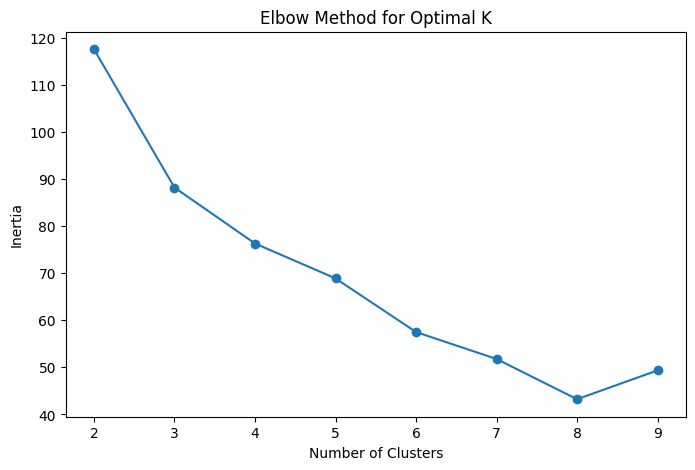


Genre Percentage in Each Cluster:

genre    classical  country  hip-hop    pop  rock
Cluster                                          
0             0.00    35.71     0.00  64.29   0.0
1             0.00    29.58    29.58  23.94  16.9
2            87.50     0.00     0.00  12.50   0.0
3             0.00    10.00    30.00   0.00  60.0
4            83.33     0.00     0.00  16.67   0.0


<ipython-input-28-18f7297487bf>:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df["Cluster"], palette="pastel")


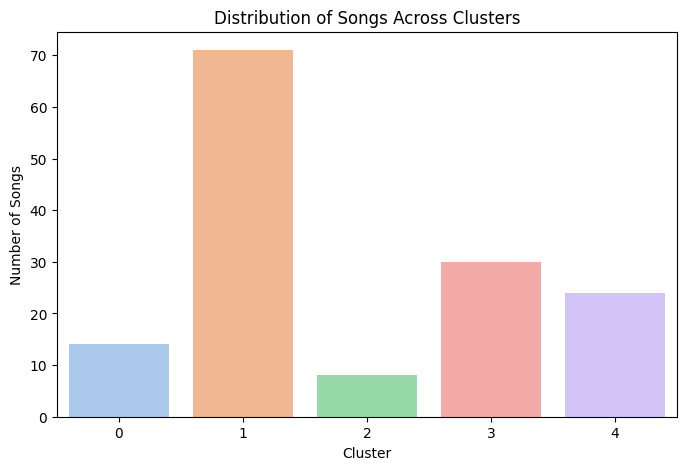

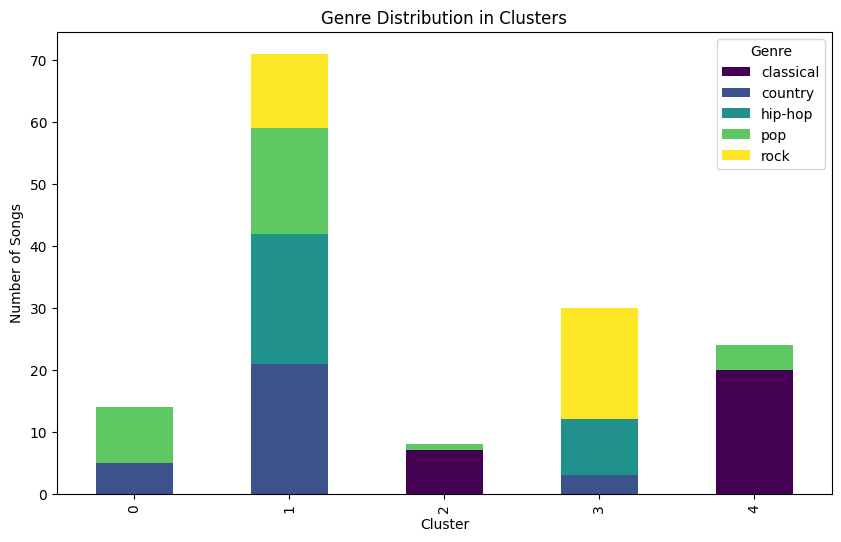

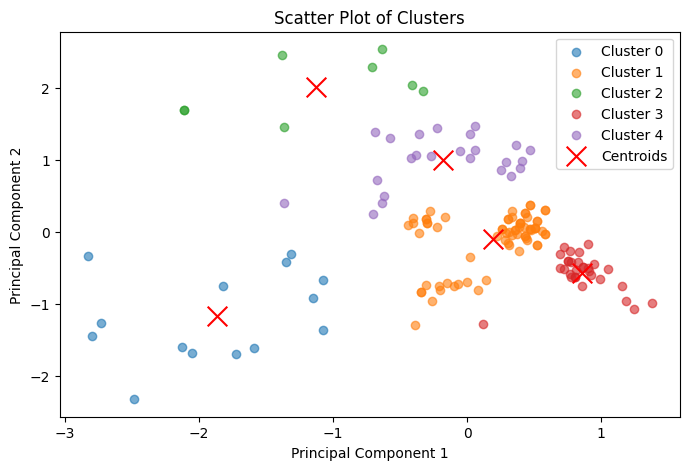

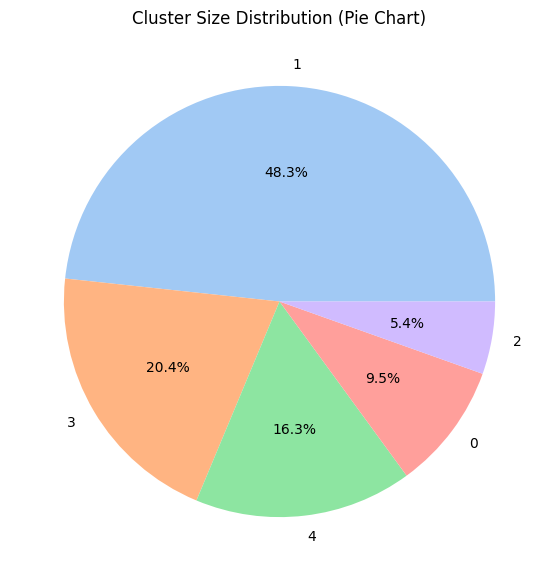

<ipython-input-28-18f7297487bf>:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')


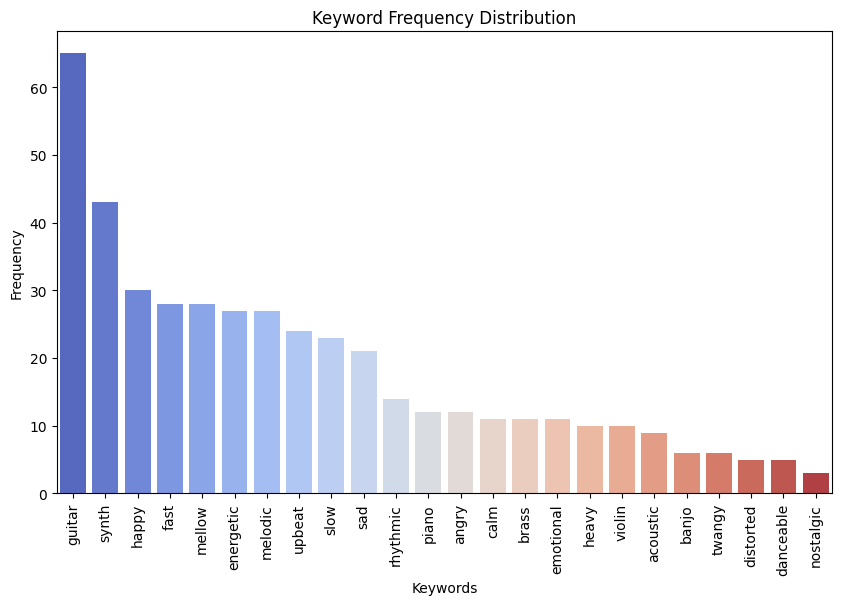

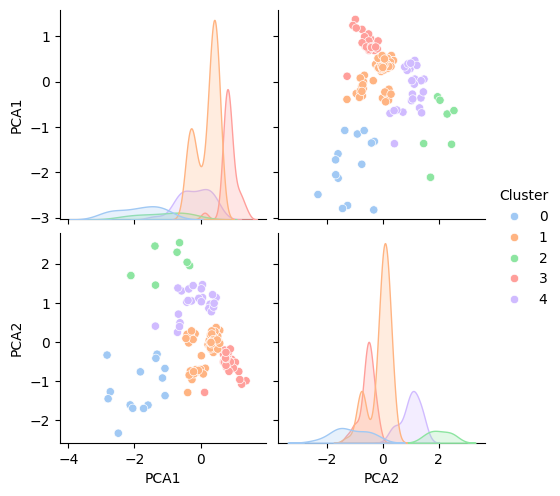

<ipython-input-28-18f7297487bf>:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=silhouette_scores, palette='pastel')


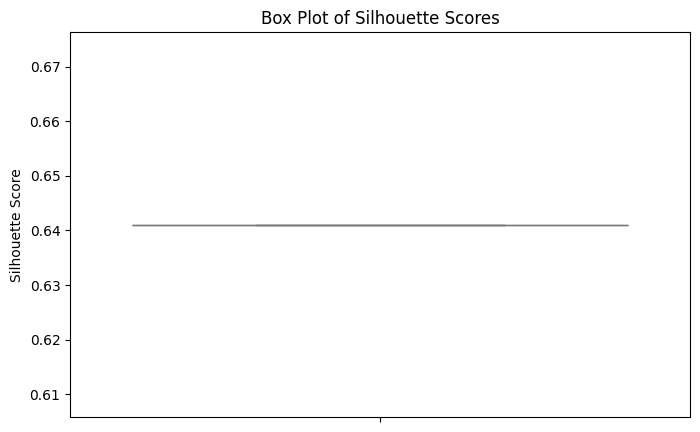

Silhouette Score: 0.6410
Adjusted Rand Index: 0.2094
Davies-Bouldin Index: 0.8007
Predicted genre for ['piano', 'calm', 'slow']: classical
Predicted genre for ['guitar', 'emotional', 'distorted']: rock
Predicted genre for ['synth', 'mellow', 'distorted']: hip-hop


In [28]:
### Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
### Cell 2: Define the MusicClustering Class
class MusicClustering:
    def __init__(self, file_path,use_average_embedding=False, embedding_dim=50):
        self.df = pd.read_csv(file_path)
        self.keyword_vectors = None
        self.final_embeddings = None
        self.labels = None
        self.centroids = None
        self.mean_vec = None
        self.principal_components = None
        self.use_average_embedding = use_average_embedding  # Store the flag
        self.embedding_dim = embedding_dim  # Store the embedding dimension
        self.word_vectors = {}  # Initialize an empty dictionary to store word embeddings

    def compute_tfidf(self):
        keywords = self.df[['keyword_1', 'keyword_2', 'keyword_3']]
        unique_keywords = np.unique(keywords.values)
        keyword_to_index = {word: i for i, word in enumerate(unique_keywords)}

        term_frequency = np.zeros((len(self.df), len(unique_keywords)))
        for i, row in self.df.iterrows():
            for word in row[['keyword_1', 'keyword_2', 'keyword_3']]:
                term_frequency[i, keyword_to_index[word]] += 1

        document_frequency = np.sum(term_frequency > 0, axis=0)
        idf = np.log(len(self.df) / (document_frequency + 1))
        self.keyword_vectors = term_frequency * idf

    def compute_average_embedding(self):
        # 1. Create a vocabulary of unique keywords
        keywords = self.df[['keyword_1', 'keyword_2', 'keyword_3']]
        unique_keywords = np.unique(keywords.values)

        # 2. Assign random embeddings to each unique keyword
        for word in unique_keywords:
            self.word_vectors[word] = np.random.rand(self.embedding_dim)  # Random embedding

        # 3. Calculate average embeddings for each song
        embeddings = []
        for i, row in self.df.iterrows():
            song_vectors = []
            for word in row[['keyword_1', 'keyword_2', 'keyword_3']]:
                if word in self.word_vectors:
                    song_vectors.append(self.word_vectors[word])

            if song_vectors:
                embeddings.append(np.mean(song_vectors, axis=0))  # Average embedding
            else:
                embeddings.append(np.zeros(self.embedding_dim))  # Default if no embeddings found

        self.keyword_vectors = np.array(embeddings)


### Cell 3: Apply PCA for Dimensionality Reduction
    def apply_pca(self):
        self.mean_vec = np.mean(self.keyword_vectors, axis=0)
        centered_data = self.keyword_vectors - self.mean_vec
        cov_matrix = np.dot(centered_data.T, centered_data) / (len(centered_data) - 1)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.principal_components = eigenvectors[:, sorted_indices[:2]]
        reduced_vectors = np.dot(centered_data, self.principal_components)
        self.final_embeddings = reduced_vectors

### Cell 4: Determine Optimal K using Elbow Method
    def elbow_method(self, k_range=range(2, 10)):
        inertia = []
        for k in k_range:
            centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
            for _ in range(10):
                distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - centroids) ** 2).sum(axis=2))
                labels = np.argmin(distances, axis=1)
                centroids = np.array([self.final_embeddings[labels == j].mean(axis=0) for j in range(k)])
            inertia.append(np.sum(np.min(distances, axis=1)))

        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.show()

### Cell 5: Perform K-Means Clustering
    def k_means_clustering(self, k=5):
        self.centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
        for _ in range(10):
            distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
            self.labels = np.argmin(distances, axis=1)
            self.centroids = np.array([self.final_embeddings[self.labels == j].mean(axis=0) for j in range(k)])
        self.df['Cluster'] = self.labels

### percentage of genre in clusters
    def genre_percentage_in_clusters(self):
        genre_cluster_distribution = self.df.groupby(["Cluster", "genre"]).size().unstack(fill_value=0)
        genre_percentage = genre_cluster_distribution.div(genre_cluster_distribution.sum(axis=1), axis=0) * 100
        print("\nGenre Percentage in Each Cluster:\n")
        print(genre_percentage.round(2))

### Cell 6: Analyze Clusters with Visualizations
    def analyze_clusters(self):
        plt.figure(figsize=(8, 5))
        sns.countplot(x=self.df["Cluster"], palette="pastel")
        plt.xlabel("Cluster")
        plt.ylabel("Number of Songs")
        plt.title("Distribution of Songs Across Clusters")
        plt.show()

        genre_cluster_distribution = self.df.groupby(["Cluster", "genre"]).size().unstack(fill_value=0)
        genre_cluster_distribution.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
        plt.xlabel("Cluster")
        plt.ylabel("Number of Songs")
        plt.title("Genre Distribution in Clusters")
        plt.legend(title="Genre")
        plt.show()

        # Scatter plot for cluster visualization
        plt.figure(figsize=(8, 5))
        for cluster in np.unique(self.labels):
            plt.scatter(self.final_embeddings[self.labels == cluster, 0],
                        self.final_embeddings[self.labels == cluster, 1],
                        label=f'Cluster {cluster}', alpha=0.6)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='x', s=200, color='red', label='Centroids')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Scatter Plot of Clusters')
        plt.legend()
        plt.show()

        # Cluster Size Distribution - Pie Chart
        plt.figure(figsize=(7, 7))
        self.df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title('Cluster Size Distribution (Pie Chart)')
        plt.ylabel('')
        plt.show()

        # Keyword Frequency Plot
        keyword_series = self.df[['keyword_1', 'keyword_2', 'keyword_3']].stack().value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')
        plt.xticks(rotation=90)
        plt.xlabel('Keywords')
        plt.ylabel('Frequency')
        plt.title('Keyword Frequency Distribution')
        plt.show()

        # Pairplot for clusters
        plot_df = pd.DataFrame({
            'PCA1': self.final_embeddings[:, 0],
            'PCA2': self.final_embeddings[:, 1],
            'Cluster': self.labels
        })
        sns.pairplot(plot_df, hue='Cluster', palette='pastel', diag_kind='kde')
        plt.show()

        # Box Plot of Silhouette Scores
        silhouette_scores = [self.silhouette_score_np() for _ in range(10)]
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=silhouette_scores, palette='pastel')
        plt.ylabel('Silhouette Score')
        plt.title('Box Plot of Silhouette Scores')
        plt.show()

### Cell 7: Compute Evaluation Metrics
    def silhouette_score_np(self):
        unique_labels = np.unique(self.labels)
        silhouette_scores = []
        for i in range(len(self.final_embeddings)):
            same_cluster = self.final_embeddings[self.labels == self.labels[i]]
            other_clusters = self.final_embeddings[self.labels != self.labels[i]]
            a = np.mean(np.sqrt(((same_cluster - self.final_embeddings[i]) ** 2).sum(axis=1)))
            b = np.mean(np.sqrt(((other_clusters - self.final_embeddings[i]) ** 2).sum(axis=1)))
            silhouette_scores.append((b - a) / max(a, b))
        return np.mean(silhouette_scores)

    def adjusted_rand_index(self,labels_true, labels_pred):
        # Create contingency table
        df = pd.DataFrame({'true': labels_true, 'pred': labels_pred})
        contingency_matrix = df.groupby(['true', 'pred']).size().unstack(fill_value=0).values
        # Sum over rows & columns
        row_sums = contingency_matrix.sum(axis=1)
        col_sums = contingency_matrix.sum(axis=0)
        total = contingency_matrix.sum()
        # Compute combinations
        def comb2(n):
            return (n * (n - 1)) // 2  # Equivalent to binomial coefficient C(n,2)
        sum_nij = np.sum(comb2(contingency_matrix))  # Sum of pairs within clusters
        sum_ai = np.sum(comb2(row_sums))  # Sum of pairs within true labels
        sum_bj = np.sum(comb2(col_sums))  # Sum of pairs within predicted clusters
        total_pairs = comb2(total)
        # Compute ARI
        expected_index = (sum_ai * sum_bj) / total_pairs
        max_index = 0.5 * (sum_ai + sum_bj)
        if max_index == expected_index:  # Avoid division by zero
           return 1.0
        ari = (sum_nij - expected_index) / (max_index - expected_index)
        return ari

    def davies_bouldin_index(self):
        cluster_distances = [np.mean(np.sqrt(((self.final_embeddings[self.labels == i] - self.centroids[i]) ** 2).sum(axis=1))) for i in np.unique(self.labels)]
        db_index = np.mean([max((cluster_distances[i] + cluster_distances[j]) / np.linalg.norm(self.centroids[i] - self.centroids[j]) for j in range(len(cluster_distances)) if i != j) for i in range(len(cluster_distances))])
        return db_index

    def predict_genre(self, keywords):
        # Create a frequency table of keyword occurrences per genre
        genre_keyword_counts = self.df.melt(id_vars=['genre'], value_vars=['keyword_1', 'keyword_2', 'keyword_3'])
        genre_keyword_counts = genre_keyword_counts.groupby(['genre', 'value']).size().unstack(fill_value=0)
        # Sum the frequency counts for the given keywords
        genre_scores = genre_keyword_counts.reindex(columns=keywords, fill_value=0).sum(axis=1)
        # Assign genre with highest score
        return genre_scores.idxmax()

### Cell 8: Main Execution
music_cluster = MusicClustering("TASK2_dataset.csv",use_average_embedding=True, embedding_dim=50)  #IF False then average embedding wont be used
music_cluster.compute_tfidf()
music_cluster.apply_pca()
music_cluster.elbow_method()
music_cluster.k_means_clustering(k=5)
music_cluster.genre_percentage_in_clusters()
music_cluster.analyze_clusters()

print(f"Silhouette Score: {music_cluster.silhouette_score_np():.4f}")
print(f"Adjusted Rand Index: {music_cluster.adjusted_rand_index(music_cluster.df['genre'], music_cluster.labels):.4f}")
print(f"Davies-Bouldin Index: {music_cluster.davies_bouldin_index():.4f}")

new_songs = [['piano', 'calm', 'slow'], ['guitar', 'emotional', 'distorted'], ['synth', 'mellow', 'distorted']]
for song in new_songs:
    predicted_genre = music_cluster.predict_genre(song)
    print(f"Predicted genre for {song}: {predicted_genre}")

Using Binary Encoding for Vectorization


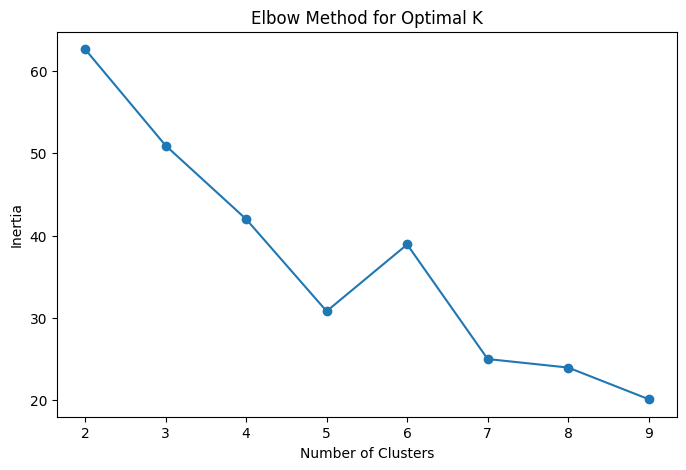


Genre Percentage in Each Cluster:

genre    classical  country  hip-hop    pop   rock
Cluster                                           
0             0.00     0.00    70.59  29.41   0.00
1            35.29     5.88    35.29  23.53   0.00
2            75.00     8.33     0.00  16.67   0.00
3            63.16    21.05     0.00  15.79   0.00
4             0.00    35.38     0.00  18.46  46.15


<ipython-input-50-5527f5e8edaf>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=self.df['Cluster'], palette='pastel')


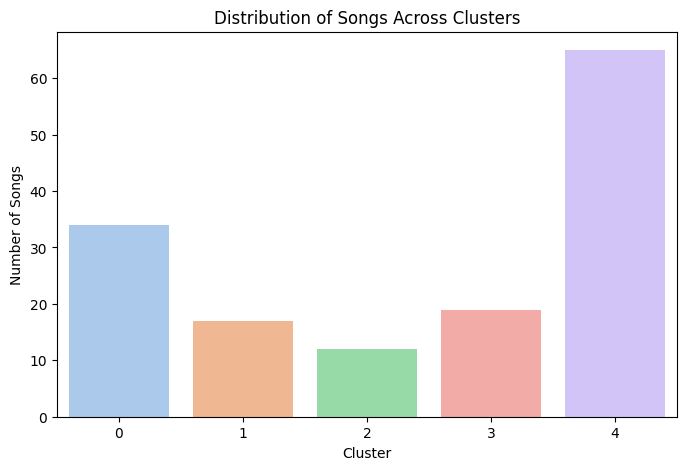

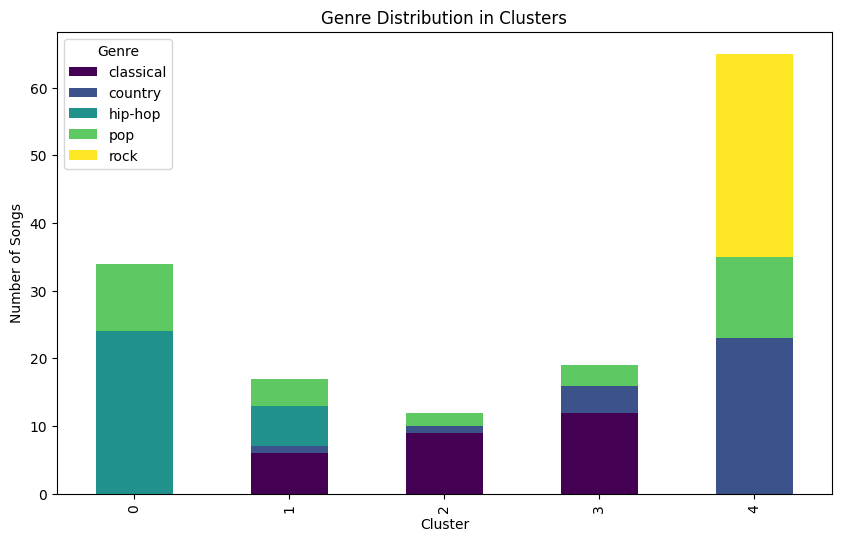

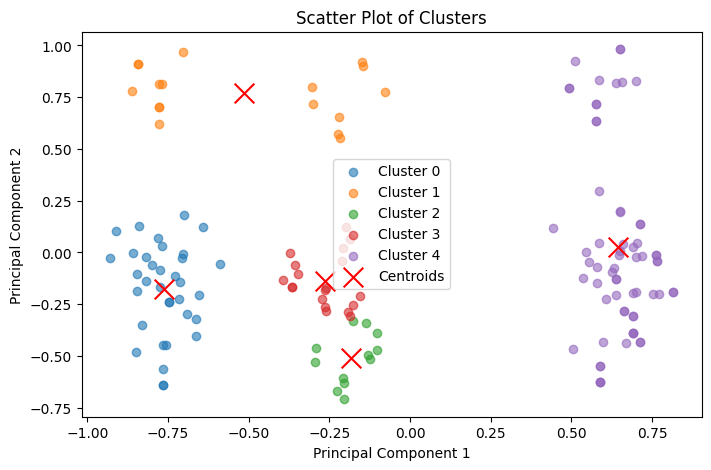

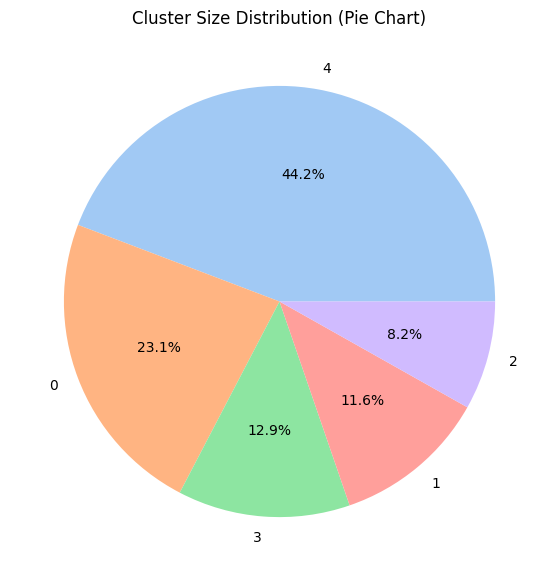

<ipython-input-50-5527f5e8edaf>:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')


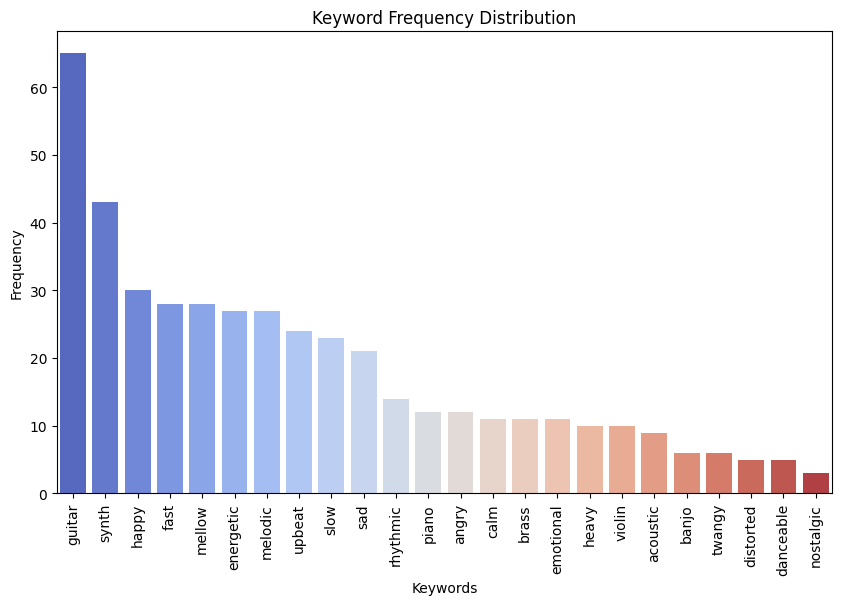

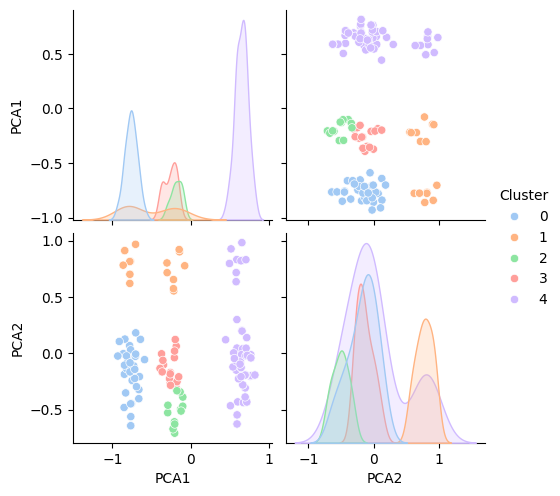

<ipython-input-50-5527f5e8edaf>:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=silhouette_scores, palette='pastel')


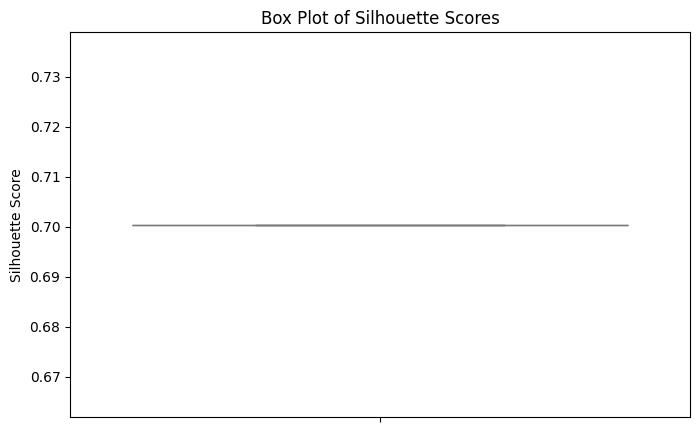

Silhouette Score: 0.7004
Adjusted Rand Index: 0.3233
Davies-Bouldin Index: 0.6194
Predicted genre for ['piano', 'calm', 'slow']: classical
Predicted genre for ['guitar', 'emotional', 'distorted']: rock
Predicted genre for ['synth', 'mellow', 'distorted']: hip-hop


In [50]:
### Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Cell 2: Define the MusicClustering Class
class MusicClustering:
    def __init__(self, file_path,use_average_embedding=False, embedding_dim=50):
        self.df = pd.read_csv(file_path)
        self.keyword_vectors = None
        self.final_embeddings = None
        self.labels = None
        self.centroids = None
        self.mean_vec = None
        self.principal_components = None
        self.use_average_embedding = use_average_embedding  # Store the flag
        self.embedding_dim = embedding_dim  # Store the embedding dimension
        self.word_vectors = {}  # Initialize an empty dictionary to store word embeddings


    def compute_binary_encoding(self):
          keywords = self.df[['keyword_1', 'keyword_2', 'keyword_3']].astype(str)
          unique_keywords = np.unique(keywords.values.flatten())  # Get all unique words
          keyword_to_index = {word: i for i, word in enumerate(unique_keywords)}
          binary_vectors = np.zeros((len(self.df), len(unique_keywords)))
          for i, row in self.df.iterrows():
              word_list = row[['keyword_1', 'keyword_2', 'keyword_3']].tolist()
            # Mark presence with 1, no counting
              for word in set(word_list):  # Use set() to avoid duplicate words
                  if word in keyword_to_index:
                      binary_vectors[i, keyword_to_index[word]] = 1  #set to 1
          self.keyword_vectors = binary_vectors # Assign the result to self.keyword_vectors
          return binary_vectors

    def compute_average_embedding(self):
        # 1. Create a vocabulary of unique keywords
        keywords = self.df[['keyword_1', 'keyword_2', 'keyword_3']]
        unique_keywords = np.unique(keywords.values)

        # 2. Assign random embeddings to each unique keyword
        for word in unique_keywords:
            self.word_vectors[word] = np.random.rand(self.embedding_dim)  # Random embedding

        # 3. Calculate average embeddings for each song
        embeddings = []
        for i, row in self.df.iterrows():
            song_vectors = []
            for word in row[['keyword_1', 'keyword_2', 'keyword_3']]:
                if word in self.word_vectors:
                    song_vectors.append(self.word_vectors[word])

            if song_vectors:
                embeddings.append(np.mean(song_vectors, axis=0))  # Average embedding
            else:
                embeddings.append(np.zeros(self.embedding_dim))  # Default if no embeddings found

        self.keyword_vectors = np.array(embeddings)

### Cell 3: Apply PCA for Dimensionality Reduction
    def apply_pca(self):
        self.mean_vec = np.mean(self.keyword_vectors, axis=0)
        centered_data = self.keyword_vectors - self.mean_vec
        cov_matrix = np.dot(centered_data.T, centered_data) / (len(centered_data) - 1)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.principal_components = eigenvectors[:, sorted_indices[:2]]
        reduced_vectors = np.dot(centered_data, self.principal_components)
        self.final_embeddings = reduced_vectors

### Cell 4: Determine Optimal K using Elbow Method
    def elbow_method(self, k_range=range(2, 10)):
        inertia = []
        for k in k_range:
            centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
            for _ in range(10):
                distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - centroids) ** 2).sum(axis=2))
                labels = np.argmin(distances, axis=1)
                centroids = np.array([self.final_embeddings[labels == j].mean(axis=0) for j in range(k)])
            inertia.append(np.sum(np.min(distances, axis=1)))

        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.show()

### Cell 5: Perform K-Means Clustering
    def k_means_clustering(self, k=5):
        self.centroids = self.final_embeddings[np.random.choice(self.final_embeddings.shape[0], k, replace=False)]
        for _ in range(10):
            distances = np.sqrt(((self.final_embeddings[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
            self.labels = np.argmin(distances, axis=1)
            self.centroids = np.array([self.final_embeddings[self.labels == j].mean(axis=0) for j in range(k)])
        self.df['Cluster'] = self.labels

###To print Percentage of genre
    def genre_percentage_in_clusters(self):
        genre_cluster_distribution = self.df.groupby(["Cluster", "genre"]).size().unstack(fill_value=0)
        genre_percentage = genre_cluster_distribution.div(genre_cluster_distribution.sum(axis=1), axis=0) * 100
        print("\nGenre Percentage in Each Cluster:\n")
        print(genre_percentage.round(2))

### Cell 6: Analyze Clusters with Visualizations
    def analyze_clusters(self):
        plt.figure(figsize=(8, 5))
        sns.countplot(x=self.df['Cluster'], palette='pastel')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Songs')
        plt.title('Distribution of Songs Across Clusters')
        plt.show()

        genre_cluster_distribution = self.df.groupby(['Cluster', 'genre']).size().unstack(fill_value=0)
        genre_cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Songs')
        plt.title('Genre Distribution in Clusters')
        plt.legend(title='Genre')
        plt.show()

        # Scatter plot for cluster visualization
        plt.figure(figsize=(8, 5))
        for cluster in np.unique(self.labels):
            plt.scatter(self.final_embeddings[self.labels == cluster, 0],
                        self.final_embeddings[self.labels == cluster, 1],
                        label=f'Cluster {cluster}', alpha=0.6)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='x', s=200, color='red', label='Centroids')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Scatter Plot of Clusters')
        plt.legend()
        plt.show()

        # Cluster Size Distribution - Pie Chart
        plt.figure(figsize=(7, 7))
        self.df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title('Cluster Size Distribution (Pie Chart)')
        plt.ylabel('')
        plt.show()

        # Keyword Frequency Plot
        keyword_series = self.df[['keyword_1', 'keyword_2', 'keyword_3']].stack().value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=keyword_series.index, y=keyword_series.values, palette='coolwarm')
        plt.xticks(rotation=90)
        plt.xlabel('Keywords')
        plt.ylabel('Frequency')
        plt.title('Keyword Frequency Distribution')
        plt.show()

        # Pairplot for clusters
        plot_df = pd.DataFrame({
            'PCA1': self.final_embeddings[:, 0],
            'PCA2': self.final_embeddings[:, 1],
            'Cluster': self.labels
        })
        sns.pairplot(plot_df, hue='Cluster', palette='pastel', diag_kind='kde')
        plt.show()

        # Box Plot of Silhouette Scores
        silhouette_scores = [self.silhouette_score_np() for _ in range(10)]
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=silhouette_scores, palette='pastel')
        plt.ylabel('Silhouette Score')
        plt.title('Box Plot of Silhouette Scores')
        plt.show()

### Cell 7: Compute Evaluation Metrics
    def silhouette_score_np(self):
        unique_labels = np.unique(self.labels)
        silhouette_scores = []
        for i in range(len(self.final_embeddings)):
            same_cluster = self.final_embeddings[self.labels == self.labels[i]]
            other_clusters = self.final_embeddings[self.labels != self.labels[i]]
            a = np.mean(np.sqrt(((same_cluster - self.final_embeddings[i]) ** 2).sum(axis=1)))
            b = np.mean(np.sqrt(((other_clusters - self.final_embeddings[i]) ** 2).sum(axis=1)))
            silhouette_scores.append((b - a) / max(a, b))
        return np.mean(silhouette_scores)

    def adjusted_rand_index(self,labels_true, labels_pred):
        # Create contingency table
        df = pd.DataFrame({'true': labels_true, 'pred': labels_pred})
        contingency_matrix = df.groupby(['true', 'pred']).size().unstack(fill_value=0).values
        # Sum over rows & columns
        row_sums = contingency_matrix.sum(axis=1)
        col_sums = contingency_matrix.sum(axis=0)
        total = contingency_matrix.sum()
        # Compute combinations
        def comb2(n):
            return (n * (n - 1)) // 2  # Equivalent to binomial coefficient C(n,2)
        sum_nij = np.sum(comb2(contingency_matrix))  # Sum of pairs within clusters
        sum_ai = np.sum(comb2(row_sums))  # Sum of pairs within true labels
        sum_bj = np.sum(comb2(col_sums))  # Sum of pairs within predicted clusters
        total_pairs = comb2(total)
        # Compute ARI
        expected_index = (sum_ai * sum_bj) / total_pairs
        max_index = 0.5 * (sum_ai + sum_bj)
        if max_index == expected_index:  # Avoid division by zero
           return 1.0
        ari = (sum_nij - expected_index) / (max_index - expected_index)
        return ari

    def davies_bouldin_index(self):
        cluster_distances = [np.mean(np.sqrt(((self.final_embeddings[self.labels == i] - self.centroids[i]) ** 2).sum(axis=1))) for i in np.unique(self.labels)]
        db_index = np.mean([max((cluster_distances[i] + cluster_distances[j]) / np.linalg.norm(self.centroids[i] - self.centroids[j]) for j in range(len(cluster_distances)) if i != j) for i in range(len(cluster_distances))])
        return db_index

    def predict_genre(self, keywords):
        # Create a frequency table of keyword occurrences per genre
        genre_keyword_counts = self.df.melt(id_vars=['genre'], value_vars=['keyword_1', 'keyword_2', 'keyword_3'])
        genre_keyword_counts = genre_keyword_counts.groupby(['genre', 'value']).size().unstack(fill_value=0)
        # Sum the frequency counts for the given keywords
        genre_scores = genre_keyword_counts.reindex(columns=keywords, fill_value=0).sum(axis=1)
        # Assign genre with highest score
        return genre_scores.idxmax()

### Cell 8: Main Execution
music_cluster = MusicClustering("TASK2_dataset.csv", use_average_embedding=True, embedding_dim=50)  # Set flag and embedding dimension.IF False then average embedding wont be use
print("Using Binary Encoding for Vectorization")
music_cluster.compute_binary_encoding()
music_cluster.apply_pca()
music_cluster.elbow_method()
music_cluster.k_means_clustering(k=5)
music_cluster.genre_percentage_in_clusters()
music_cluster.analyze_clusters()

print(f"Silhouette Score: {music_cluster.silhouette_score_np():.4f}")
print(f"Adjusted Rand Index: {music_cluster.adjusted_rand_index(music_cluster.df['genre'], music_cluster.labels):.4f}")
print(f"Davies-Bouldin Index: {music_cluster.davies_bouldin_index():.4f}")

# Predict genres for new songs
# Predict genres for new songs
new_songs = [['piano', 'calm', 'slow'], ['guitar', 'emotional', 'distorted'], ['synth', 'mellow', 'distorted']]
for song in new_songs:
    predicted_genre = music_cluster.predict_genre(song)
    print(f"Predicted genre for {song}: {predicted_genre}")